## 支持向量机
支持向量机(Support Vector Machine，SVM)是一种功能强大且用途广泛的机器学习模型，能够执行线性或非线性分类、回归，甚至异常检测。

SVM在中小型非线性数据集（即成百上千个实例）中大放异彩，尤其适用于分类任务。然而，它们不能很好地扩展到非常大的数据集（会讲一下它训练的所需时间 和 样本大小m/特征大小n的关系。）

教学顺序：SVM核心概念（目的是什么），如何使用，以及工作原理（了解即可，要涉及数学专业研究生学的数学， 凸优化）

### 线性SVM分类
SVM的基本思想可以用图来说明。下图所示的数据集来自鸢尾花数据集的一部分。两个类别可以轻松地被一条直线（它们是线性可分离的）分开。左图显示了三种可能的线性分类器的决策边界。决策边界用虚线表示的模型表现非常糟糕，它甚至都无法正确实现分类。其余两个模型在这个训练集上表现堪称完美，但是它们的决策边界与实例过于接近，从而导致在面对新实例时，表现可能不会太好。相比之下，右图中的实线代表SVM分类器的决策边界，这条线不仅分离了两个类，并且尽可能远离了最近的训练实例。

![大间隔分类](./images/svm/p1.png)

可以将SVM分类器视为在类之间拟合可能的最宽的街道（由平行的虚线表示）。因此这也叫作大间隔分类(large margin classification)。

注意：
1. SVM训练后，在“街道以外”的地方增加更多的训练实例根本不会对决策边界产生影响，也就是说，它完全由位于街道边缘的实例所决定（或者“支持”）。这些实例被称为支持向量

2. 支持向量对特征缩放敏感，如下图所示，在左图中，垂直刻度比水平刻度大得多，因此可能的最宽街道接近于水平，其中一个特征看起来毫无作用，在特征缩放（例如使用Scikit-Learn的StandardScaler）后，决策边界看起来好很多（见右图）

![决策边界对特征缩放敏感](./images/svm/p2.png)

#### 软间隔分类

如果严格地让所有实例都在街道以外，并且位于正确的一边，这就是硬间隔分类。硬间隔分类有两个主要问题：首先，它只在数据是线性可分离的时候才有效；其次，它对异常值非常敏感。下图显示了有一个额外异常值的鸢尾花数据：左图的数据根本找不出硬间隔，而右图最终显示的决策边界与之前的图所看到的无异常值时的决策边界也大不相同，这个模型可能无法很好地泛化。

![硬间隔对异常值的敏感度](./images/svm/p3.png)

要避免这些问题，需要使用更灵活的模型。目标是在保持街道尽可能宽阔和限制间隔违规（即位于街道之上，甚至在错误的一边的实例）之间找到良好的平衡，这就是软间隔分类

软间隔：目标是在保持街道尽可能宽阔和限制间隔违规（即位于街道之上，甚至在错误的一边的实例）之间找到良好的平衡，这就是软间隔分类。

在使用Scikit-Learn创建SVM模型时，可以指定多个超参数，包括正则化超参数C。

如果将其设置为较小的值，则最终会得到下图左侧的模型。如果将其设置为较大的值，则将获得下图右侧的模型。

![大间隔和较少的间隔违例](./images/svm/p4.png)


减小C（提高正则化强度）会使街道变宽，但也会导致更多的间隔违例(margin violation)。换句话说，减小C会导致更多实例支持街道，因此过拟合的风险较小, 如果减小太多，会导致欠拟合

图中的实现：wx+b=0确定的边界， 街道宽度怎么确定？：wx+b=1 （图中的虚线）（平面1）， wx+b=-1 （图里的虚线）（平面2）； 2*宽度 = 平面1和平面2之间的距离


In [2]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline

iris = load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris.target == 2  # 二元分类问题
svm_clf = make_pipeline(StandardScaler(), LinearSVC(C=1, random_state=42, dual=True)) # dual=True为了消除警告用的， dual决定内部是怎么训练的 SVM
svm_clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(C=1, dual=True, random_state=42))])

In [3]:
X_new = [[5.5,1.7], [5.0,1.5]]
svm_clf.predict(X_new)

#  支持向量机的决策函数
svm_clf.decision_function(X_new)

# svm_clf[-1]  # 得到了流水线的最后一个组件，现在是LinearSVC
# svm_clf[-1].predict_proba() # LinearSVC没有预测概率 这里会报错



array([ 0.66163411, -0.22036063])

第一种植物被归类为Virginica鸢尾花(正类，1），而第二种（负类）则不是。 SVM用来做出这些预测的分数测量每个实例和决策边界之间的有符号距离

与LogisticRegression不同，LinearSVC没有predict_proba()方法来估计类概率

如果使用SVC类而不是LinearSVC，并且将其probability超参数设置为True，则该模型将在训练结束时拟合一个额外的模型以把SVM决策函数分数映射到估计的概率。在底层，这需要使用5折交叉验证为训练集中的每个实例生成样本外预测，然后训练LogisticRegression模型，因此它会大大减慢训练速度。之后，predict_proba()和predict_log_proba()方法就可用了。

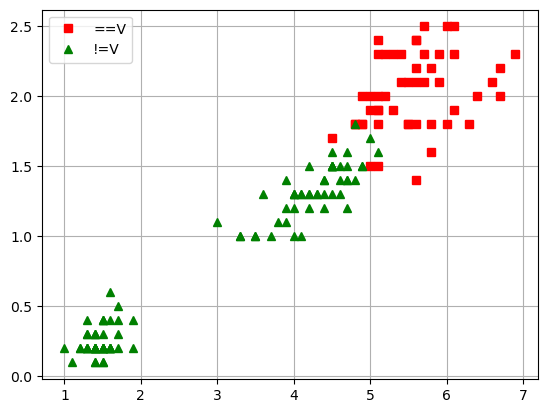

In [4]:
# 1. 画数据集，确定可以SVM用 线性分类（y = iris.target == 2  # 二元分类问题）
import matplotlib.pyplot as plt
plt.plot(X[y==True, 0], X[y==True,1], "rs", label="==V")
plt.plot(X[y==False, 0], X[y==False,1], "g^", label="!=V")

plt.legend()
plt.grid(True)
plt.show()


In [5]:
# 2. 调用时候SVC（） 设置probability为True，
from sklearn.svm import SVC
svm_clf2 = make_pipeline(StandardScaler(), SVC(C=1, random_state=42, probability=True))
# 3. 训练
svm_clf2.fit(X, y)
# 4. 训练结束，看看能不能预测 特征 属于 0/1类的概率
# X_new = [[5.5,1.7], [5.0,1.5]]
svm_clf2.predict_proba(X_new)

array([[0.07978788, 0.92021212],
       [0.7960643 , 0.2039357 ]])

### 非线性SVM分类
在许多情况下，线性SVM分类器是有效的，并且效果还可以，但是，有很多数据集远不是线性可分离的。处理非线性数据集的方法之一是添加更多特征，比如多项式特征


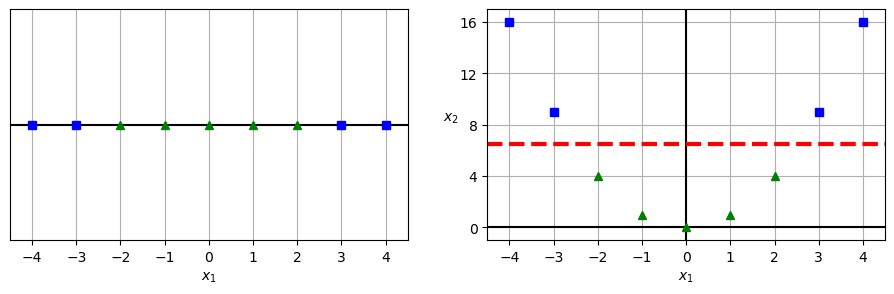

In [6]:
# 一个简单的数据集，只有一个特征x1。可以看出，数据集不是线性可分离的。但是如果添加第二个特征x2=(x1)2，生成的2D数据集则是完全线性可分离的。
import numpy as np
import matplotlib.pyplot as plt

X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
X2D = np.c_[X1D, X1D**2]
y = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(10, 3))

plt.subplot(121)  # plt.subplot(1,2,1)
plt.grid(True)
plt.axhline(y=0, color='k')  # 纵坐标y=0画了一条水平线
plt.plot(X1D[:, 0][y==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][y==1], np.zeros(5), "g^")


# plt.gca(): 获取当前Axes（获取当前的子图）
plt.gca().get_yaxis().set_ticks([])  # 去掉当前子图的y轴刻度
plt.xlabel("$x_1$")
plt.axis([-4.5, 4.5, -0.2, 0.2])

plt.subplot(122)
plt.grid(True)
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(X2D[:, 0][y==0], X2D[:, 1][y==0], "bs")
plt.plot(X2D[:, 0][y==1], X2D[:, 1][y==1], "g^")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$  ", rotation=0)
plt.gca().get_yaxis().set_ticks([0, 4, 8, 12, 16])
plt.plot([-4.5, 4.5], [6.5, 6.5], "r--", linewidth=3)  # 红线的代码，加了特征后的X变得线性可分
plt.axis([-4.5, 4.5, -1, 17])

plt.subplots_adjust(right=1)
plt.show()

In [7]:
from sklearn.datasets import make_moons
from sklearn.preprocessing import PolynomialFeatures
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)   # make_*生成假数据，make_moons会生成二元分类的小数据集，其中数据点的形状像两个交错的新月

polynomial_svm_clf = make_pipeline(PolynomialFeatures(degree=3),
                                   StandardScaler(),
                                   LinearSVC(C=10, max_iter=10000,random_state=42, dual=True))
polynomial_svm_clf.fit(X, y)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('standardscaler', StandardScaler()),
                ('linearsvc',
                 LinearSVC(C=10, dual=True, max_iter=10000, random_state=42))])

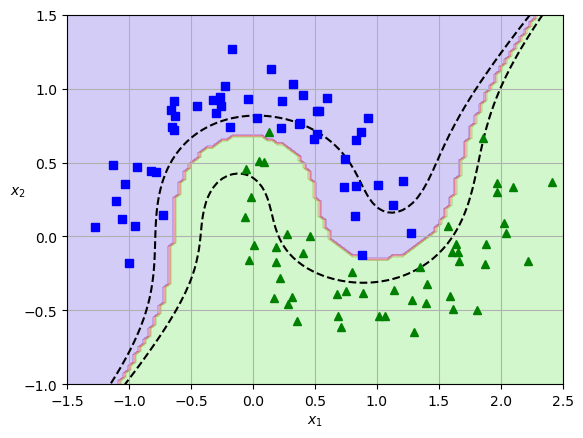

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def plot_dataset(X, y, axes):
    # axes： 坐标轴的范围，列表
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$", rotation=0)

def plot_predictions(clf, axes):
    # axes: 坐标轴的范围，列表, [x上界，x下界, y轴上界,y轴下界]
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)                     # y_pred.shape: (100,100)  里面全都是预测的分类
    y_decision = clf.decision_function(X).reshape(x0.shape)       # y_decision.shape:(100,100) 里面全都是预测的分数（相对于决策线的距离）
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)  # 根据每个网格点的预测分类（+1 或 -1），用不同颜色填充区域。颜色分界线就是 SVM 的分类边界。
    # plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=1)
    plt.contour(x0, x1, y_decision, levels=[-1, 1], colors='k', linestyles=['--',  '--']) # 画间隔，间隔 根据决策分数=+1/-1决定

# wx+b=0
# wx+b=1
# wx+b=-1

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

- 多项式核

添加多项式特征实现起来非常简单，但问题是，如果多项式太低阶，则处理不了非常复杂的数据集，而高阶则会创造出大量的特征，导致模型训练变得太慢。

在使用SVM时，有一种神奇的数学技术可以应用， 叫核技巧。  核技巧产生的效果：就跟添加了许多多项式特征（甚至非常高阶的多项式特征）一样，但实际上并不需要真的添加。这意味着特征数量不会出现组合爆炸式增长

这个技巧是由SVC类实现的


In [9]:
from sklearn.svm import SVC

#  核技巧：决定对特征做什么函数变换（不会添加任何特征）； 参数 kernel=
#   多项式核： kernel="poly:
# 使用三阶多项式核函数。coef0 是核函数中的常数项（偏置项），影响高阶与低阶项的权重。C 是正则化参数，控制间隔大小 与间隔违例的权衡：C 越大越强调训练准确率，C 越小越强调间隔更大。

# 用核技巧要解决的问题： 不添加特征，能达到特征之后去训练 一样的效果
poly_kernel_svm_clf = make_pipeline(StandardScaler(), SVC(kernel="poly", degree=3, coef0=1, C=5))
poly_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=5, coef0=1, kernel='poly'))])

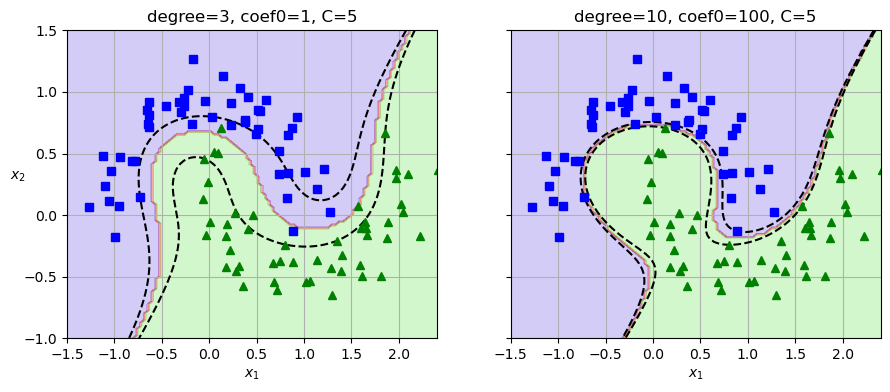

In [10]:
poly10_kernel_svm_clf = make_pipeline(
    StandardScaler(),
    SVC(kernel="poly", degree=10, coef0=100, C=5)
)
poly10_kernel_svm_clf.fit(X, y)

fig, axes = plt.subplots(ncols=2, figsize=(10.5, 4), sharey=True)

# plt.sca:  plt当前的子图（axes) 设置成指定的子图
plt.sca(axes[0])
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title("degree=3, coef0=1, C=5")

plt.sca(axes[1])
plot_predictions(poly10_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title("degree=10, coef0=100, C=5")
plt.ylabel("")
plt.show()

- 相似性特征

解决非线性问题的另一种技术是添加相似性特征。这些特征由相似函数计算得出，相似函数可以测量每个实例与一个特定地标之间的相似程度，以一维数据集为例，在x1=-2和x1=1处添加两个地标。

接下来，我们采用高斯径向基函数(RBF)作为相似函数，γ=0.3。这是一个从0（与地标距离非常远）到1（在地标位置）变化的钟形函数。

计算新特征。例如，实例x1=-1：它与第一个地标的距离为1，与第二个地标的距离为2。因此它的新特征为x2=exp(-0.3×1^2)≈0.74，x3=exp(-0.3×2^2)≈0.30。 右图显示了转换后的数据集（去除了原始特征），现在可以看出，数据变成了线性可分离的。

![使用高斯RBF的相似性特征](./images/svm/p5.png)

选择“地标”最简单的方法是在数据集里每一个实例的位置上创建一个地标。这会创造出许多维度，因而也增加了转换后的训练集线性可分离的机会。缺点是，一个有m个实例n个特征的训练集会被转换成一个有m个实例m个特征的训练集（假设抛弃了原始特征）。如果训练集非常大，那就会得到同样大数量的特征。

- 高斯RBF核

与多项式特征类似，相似性特征方法也可用于许多机器学习算法，但是要计算出所有附加特征，其计算成本可能会非常大。但使用核技巧能够产生的结果就跟添加了许多相似性特征一样，但实际上并不需要添加

以下代码是用了高斯RBF核的SVC类。

In [11]:
# 高斯RBF核函数怎么使用： kernel="rbf",对应的其他超参数 就是 gamma

rbf_kernel_svm_clf = make_pipeline(StandardScaler(), SVC(kernel="rbf",gamma=5, C=0.001))
rbf_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=0.001, gamma=5))])

增加gamma值会使钟形曲线变得更窄，因此每个实例的影响范围随之变小：决策边界变得更不规则，开始围着单个实例绕弯。

反过来，减小gamma值会使钟形曲线变得更宽，因而每个实例的影响范围增大，决策边界变得更平坦。


所以gamma就像是一个正则化的超参数：如果模型过拟合，则减小它的值；如果欠拟合，则增大它的值（类似超参数C，对过拟合/欠拟合的调整方向一致）

怎么决定使用哪一个核函数？
1. 先尝试线性核。LinearSVC类比SVC(kernel="linear")快得多，尤其是在训练集非常大的情况下
2. 如果训练集不是太大，可以尝试高斯RBF核，它通常效果可以
3. 最后再考虑使用超参数搜索来实验其他核函数

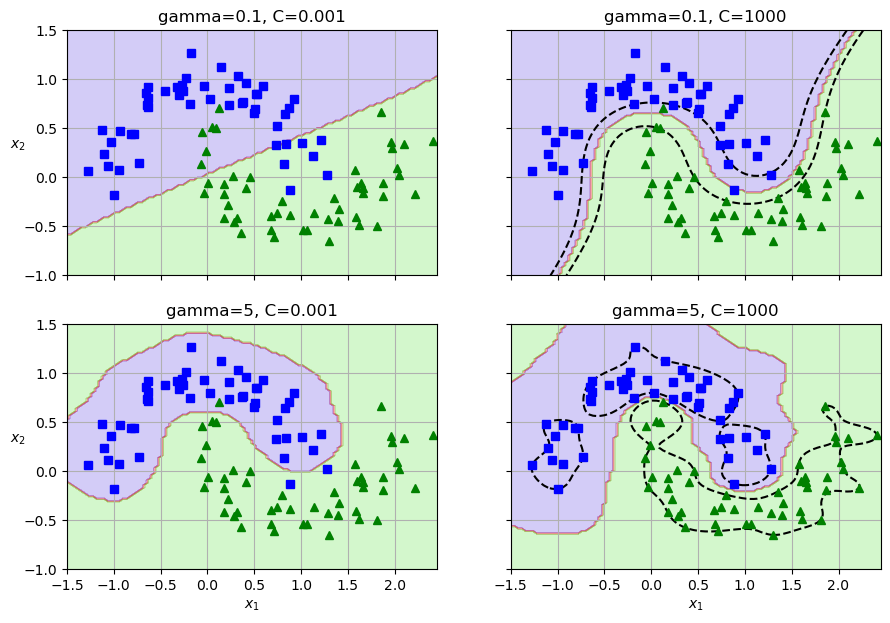

In [12]:
gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []

for gamma, C in hyperparams:
    rbf_kernel_svm_clf = make_pipeline(
        StandardScaler(),
        SVC(kernel="rbf", gamma=gamma, C=C)
    )
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10.5, 7), sharex=True, sharey=True)

for i, svm_clf in enumerate(svm_clfs):
    plt.sca(axes[i // 2, i % 2])  # 把plt的当前子图，  设置为 某行某列的子图
    plot_predictions(svm_clf, [-1.5, 2.45, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.45, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(f"gamma={gamma}, C={C}")
    if i in (0, 1):
        plt.xlabel("")
    if i in (1, 3):
        plt.ylabel("")


plt.show()

from sklearn.linear_model import SGDClassifier

#### SVM类和计算复杂度


1. LinearSVC算法不支持核技巧，但它与训练实例的数量和特征呈线性相关，其训练时间复杂度大致为O(m×n)
2. SVC类支持核技巧，训练时间复杂度通常在O(m^2×n)和O(m^3×n)之间。这意味着如果训练实例的数量变大（例如数十万个实例），它会非常慢，所以这个算法完美适用于中小型的非线性训练集。但是，它还是可以良好地适应特征数量的增加，特别是应对稀疏特征（即每个实例仅有少量的非零特征）。在这种情况下，算法复杂度大致与实例的平均非零特征数成比例。
3. SGDClassifier类也默认执行大间距分类(SVM)，其超参数——尤其是正则化超参数（alpha和penalty）和learning_rate -- 调整这个参数可以产生与线性SVM相似的结果。 它的计算复杂度也是O(m*n), 因为其训练方式，它可以在大型数据集上训练模型

![SVM分类比较](./images/svm/p6.png)

### SVM回归
使用SVM做回归的技巧是调整目标：SVM回归不是试图在两个类之间拟合最大可能的街道同时限制间隔违例，而是尝试在街道上拟合尽可能多的实例，同时限制间隔违例（即街道以外的实例），街道的宽度由超参数epsilon控制

注意：SVM做回归的支持向量是街道外的训练集

In [13]:
from sklearn.svm import LinearSVR

np.random.seed(42)
X = 2 * np.random.rand(50, 1)
y = 4 + 3 * X[:, 0] + np.random.randn(50)

svm_reg = make_pipeline(StandardScaler(),
                        LinearSVR(epsilon=0.5,  dual=True, random_state=42))
svm_reg.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvr',
                 LinearSVR(dual=True, epsilon=0.5, random_state=42))])

In [14]:
np.argwhere(np.array([True,False,True]))

array([[0],
       [2]], dtype=int64)

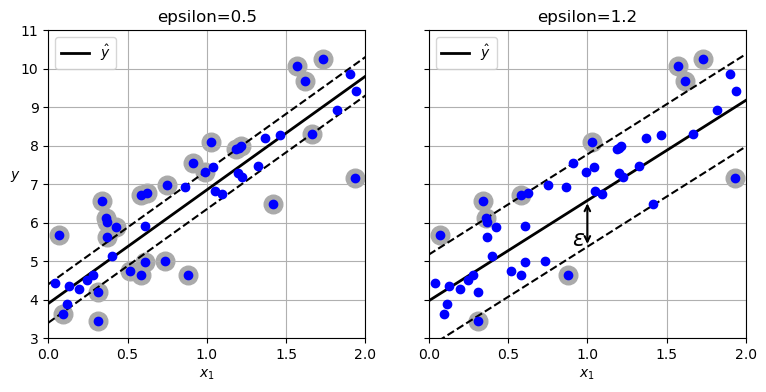

In [15]:
# 用于计算出支持向量（SVR中是落在ε之外的点）的位置索引。
def find_support_vectors(svm_reg, X, y):
    y_pred = svm_reg.predict(X)
    epsilon = svm_reg[-1].epsilon
    off_margin = np.abs(y - y_pred) >= epsilon  # 这里 布尔值的numpy数组，True： 在街道外； False:在街道内
    return np.argwhere(off_margin)  #   在街道外的数量 * 1，  每一行都是索引（off_margin为True的索引)

# 给定一个训练好的 svm_reg 模型和数据 X, y，绘制：
# SVR 的拟合曲线（预测值）
# ε 不敏感区间（ε-tube 上下边界）
# 支持向量（ε边界之外的点）

def plot_svm_regression(svm_reg, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    epsilon = svm_reg[-1].epsilon
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$")

    plt.plot(x1s, y_pred + epsilon, "k--")
    plt.plot(x1s, y_pred - epsilon, "k--")

    plt.scatter(X[svm_reg._support], y[svm_reg._support], s=180,facecolors='#AAA')
    plt.plot(X, y, "bo")
    plt.xlabel("$x_1$")
    plt.legend(loc="upper left")
    plt.axis(axes)

svm_reg2 = make_pipeline(StandardScaler(),
                         LinearSVR(epsilon=1.2, dual=True, random_state=42))
svm_reg2.fit(X, y)

svm_reg._support = find_support_vectors(svm_reg, X, y)
svm_reg2._support = find_support_vectors(svm_reg2, X, y)

eps_x1 = 1
eps_y_pred = svm_reg2.predict([[eps_x1]])

fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_reg, X, y, [0, 2, 3, 11])
plt.title(f"epsilon={svm_reg[-1].epsilon}")
plt.ylabel("$y$", rotation=0)
plt.grid()

plt.sca(axes[1])
plot_svm_regression(svm_reg2, X, y, [0, 2, 3, 11])
plt.title(f"epsilon={svm_reg2[-1].epsilon}")

# 指出边距， textcoords=data表示数据坐标系； xy箭头位置 和 xytext文字位置
plt.annotate(
        '', xy=(eps_x1, eps_y_pred), xycoords='data',
        xytext=(eps_x1, eps_y_pred - svm_reg2[-1].epsilon),
        textcoords='data', arrowprops={'arrowstyle': '<->', 'linewidth': 1.5}
    )  # 画的箭头
plt.text(0.90, 5.4, r"$\epsilon$", fontsize=16)   # 画的epsilon符号


plt.grid()
plt.show()

减小epsilon会增加支持向量的数量，从而使模型得到正则化。

此外，如果在间隔区域内添加更多的训练实例，它不会影响模型的预测。因此，该模型被称为∈不敏感。

In [22]:
# 要解决非线性回归任务，可以使用核化的SVM模型
from sklearn.svm import SVR

np.random.seed(42)
X = 2 * np.random.rand(50, 1) - 1
y = 0.2 + 0.1 * X[:, 0] + 0.5 * X[:, 0] ** 2 + np.random.randn(50) / 10

svm_poly_reg = make_pipeline(StandardScaler(),
                             SVR(kernel="poly", degree=2, C=0.01, epsilon=0.1))
svm_poly_reg.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(C=0.01, degree=2, kernel='poly'))])

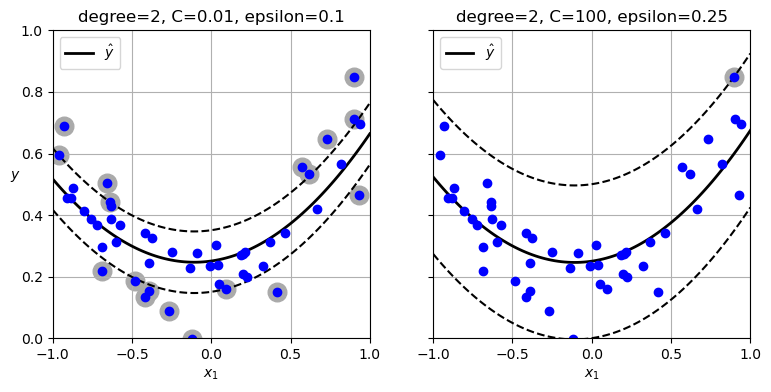

In [25]:
svm_poly_reg2 = make_pipeline(StandardScaler(),
                             SVR(kernel="poly", degree=2, C=100, epsilon=0.25))
svm_poly_reg2.fit(X, y)

svm_poly_reg._support = find_support_vectors(svm_poly_reg, X, y)
svm_poly_reg2._support = find_support_vectors(svm_poly_reg2, X, y)


# 比较不同C值的预测曲线
fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_poly_reg, X, y, [-1, 1, 0, 1])
plt.title(f"degree={svm_poly_reg[-1].degree}, "
          f"C={svm_poly_reg[-1].C}, "
          f"epsilon={svm_poly_reg[-1].epsilon}")
plt.ylabel("$y$", rotation=0)
plt.grid()

plt.sca(axes[1])
plot_svm_regression(svm_poly_reg2, X, y, [-1, 1, 0, 1])
plt.title(f"degree={svm_poly_reg2[-1].degree}, "
          f"C={svm_poly_reg2[-1].C}, "
          f"epsilon={svm_poly_reg2[-1].epsilon}")
plt.grid()
plt.show()

SVR类是SVC类的回归等价物，LinearSVR类也是LinearSVC类的回归等价物。LinearSVR与训练集的大小线性相关（跟LinearSVC一样），而SVR类则在训练集变大时，变得很慢（SVC类也是一样）

### 线性SVM分类器的工作原理

1. 预测
线性 SVM 分类器通过首先计算决策函数
$$
\boldsymbol{\theta}^T \boldsymbol{x} = \theta_0 x_0 + \theta_1 x_1 + \cdots + \theta_n x_n
$$
来预测新实例 $\boldsymbol{x}$ 的类别，其中 $x_0$ 是偏置特征（始终等于 1）。如果结果是正数，那么预测的类是阳性类（1）；否则就是阴性类（0）。这与 Logistic Regression完全一样。

2. 训练
- 第一个目标：需要找到权重w和偏置b，使街道间隔尽可能宽。
- 第二个目标：限制落在街道内的实例的数量，以及分类错误的数量（街道内 + 街道外）

- 第一个目标的数学表达：首先把街道的边界定义为决策函数（wx+b）等于1或者-1的地方。要想让边界之间的范围变宽（街道变宽），需要让w的l2范数变小。 直观的理解方式：

![较小的权重可以导致较大的间隔](./images/svm/p7.png)

在左图中，权重w1为1，因此w1x1=-1或1处的点为x1=-1和1，因此间隔的大小为2。在右图中，权重为0.5，因此w1x1=-1或1的点是x1=-2和2，间隔的大小为4。因此，需要使w尽可能小。请注意，偏置项b对间隔的大小没有影响，调整它只会移动间隔，而不会影响其大小。

- 第二个目标的数学表达：对于硬间隔来说，要想避免间隔违例，需要没有实例在街道内部，且正确分类 -> 决策函数对于所有阳性训练实例都大于等于1，对于所有阴性训练实例都小于-1。

如果定义当实例为阴性类（$\hat{y}^{(i)} = 0$）时，$t^{(i)} = -1$，当实例为阳性类（$\hat{y}^{(i)} = 1$）时，$t^{(i)} = 1$，那么我们就可以将这个约束条件写为：对所有实例来说，
$t^{(i)} (\mathbf{w}^\top \mathbf{x}^{(i)} + b) \geq 1$

因此，我们可以将硬间隔线性 SVM 分类器的目标看作一个约束优化问题，如下面公式所示。

**公式 ：硬间隔线性 SVM 分类器的目标**

$$
\begin{aligned}
\min_{\mathbf{w}, b} \quad & \frac{1}{2} \mathbf{w}^\top \mathbf{w} \\\\
\text{满足} \quad & t^{(i)} (\mathbf{w}^\top \mathbf{x}^{(i)} + b) \geq 1, \quad i = 1, 2, \cdots, m
\end{aligned}
$$

这里最小化w的l2范数，而不是w的l1范数是因为w的l2范数可以求导，l1范数在w=0时不可求导，优化算法在可求导函数上效果更好

要达到软间隔的目标，我们需要为每个实例引入一个松弛变量 $\zeta^{(i)} \geq 0$，
$\zeta^{(i)}$ 衡量的是第 $i$ 个实例多大程度上允许间隔违例。

那么现在我们有了两个互相冲突的目标：
- 使松弛变量越小越好从而减少间隔违例；
- 同时还要最小化 $\frac{1}{2} \mathbf{w}^\top \mathbf{w}$ 以增大间隔。

这里是超参数 $C$ 的用武之地：允许我们在两个目标之间权衡。下面公式给出了这个约束优化问题。

**公式 5-2：软间隔线性 SVM 分类器目标**

$$
\begin{aligned}
\min_{\mathbf{w}, b, \boldsymbol{\zeta}} \quad & \frac{1}{2} \mathbf{w}^\top \mathbf{w} + C \sum_{i=1}^m \zeta^{(i)} \\\\
\text{使得} \quad & t^{(i)} (\mathbf{w}^\top \mathbf{x}^{(i)} + b) \geq 1 - \zeta^{(i)}, \quad \zeta^{(i)} \geq 0,\quad i = 1, 2, \cdots, m
\end{aligned}
$$

硬间隔和软间隔问题都属于线性约束的凸二次优化问题。这类问题被称为二次规划（Quadratic Programming，QP）问题。
如何求解这种优化问题，属于凸优化的内容，感兴趣的可以参考这本书（不建议感兴趣，只是为了内容的完整写在这里）：

<img alt="凸优化" height="500" src="./images/svm/p8.jpg" width="500"/>



另一种训练SVM的方式（达到软间隔线性SVM分类器目标）是使用梯度下降来最小化hinge损失或平方hinge损失。hinge损失最终在优化： （不带任何约束条件->跟凸优化没有关系）
$$
\min_{\mathbf{w}, b} \quad \frac{1}{2} \|\mathbf{w}\|^2 + C \sum_{i=1}^n \max(0, 1 - y_i(\mathbf{w}^\top \mathbf{x}_i + b))
$$

这其中：

- $\max(0, 1 - y_i f(x_i))$：就是 hinge 损失函数；
- 实际上它和上面的约束 $\xi_i \geq 1 - y_i f(x_i),\ \xi_i \geq 0$ 是完全等价的。

给定阳性类的实例 $x$（即 $t = 1$），如果决策函数的输出 $s = \mathbf{w}^T \mathbf{x} + b$ 大于或等于 1，则损失为 0。这发生在该实例不在街道上，并且在正侧。

给定阴性类的实例（即 $t = -1$），如果 $s \leq -1$，则损失为 0。当实例不在街道上并且处于负侧时，就会发生这种情况。

一个实例间隔的正确侧越远，损失就越大：它对于 hinge 损失呈线性增长，对于平方 hinge 损失呈二次方增长。这使得平方 hinge 损失对异常值更加敏感。

然而，如果数据集是干净的，它往往收敛得更快。

默认情况下，`LinearSVC` 使用平方 hinge 损失，而 `SGDClassifier` 使用 hinge 损失。这两个类都允许通过超参数设置为"hinge"或"squared_hinge"来选择损失。

SVC类的优化算法找的是 和 最小化hinge损失 相似的解决方案

![hinge损失和平方hinge损失](./images/svm/p8.png)

#### 对偶问题
针对一个给定的约束优化问题（称为原始问题），常常可以用另一个不同的，但是与之密切相关的问题来表达，这个问题叫作对偶问题。

通常来说，对偶问题的解只能算是原始问题的解的下限，但是在某些情况下，它也可能跟原始问题的解完全相同。

SVM的优化问题刚好属于某些情况：对偶问题的解和原始解完全相同，所以可以选择是解决原始问题还是对偶问题。

下面公式给出了线性SVM优化的对偶形式 （不用在意推导过程，感兴趣的去读前面提到的书）

$$
\begin{aligned}
\min_{\boldsymbol{\alpha}} \quad & \frac{1}{2} \sum_{i=1}^{m} \sum_{j=1}^{m} \alpha^{(i)} \alpha^{(j)} t^{(i)} t^{(j)} \mathbf{x}^{(i)\top} \mathbf{x}^{(j)} - \sum_{i=1}^{m} \alpha^{(i)} \\
\text{使} \quad & \alpha^{(i)} \geq 0,\quad i = 1, 2, \cdots, m \\
\text{且} \quad & \sum_{i=1}^{m} \alpha^{(i)} t^{(i)} = 0
\end{aligned}
$$

一旦得到最小化该等式（使用二次规划求解器）的向量 $\hat{\boldsymbol{\alpha}}$，就可以使用下面公式  来计算最小化原始问题的 $\hat{\mathbf{w}}$ 和 $\hat{b}$。在这个公式中，$n_s$ 表示支持向量的数量，也就是非0 a(i)的数量。

$$
\hat{\mathbf{w}} = \sum_{i=1}^{m} \hat{\alpha}^{(i)} t^{(i)} \mathbf{x}^{(i)}
$$

$$
\hat{b} = \frac{1}{n_s} \sum_{\substack{i=1 \\ \hat{\alpha}^{(i)} > 0}}^{m} \left( t^{(i)} - \hat{\mathbf{w}}^\top \mathbf{x}^{(i)} \right)
$$

当训练实例的数量小于特征数量时，解决对偶问题比原始问题更快速。更重要的是，对偶问题能够实现核技巧，而原始问题不可能实现。


##### 核化SVM

假设想要将一个二阶多项式转换为一个二维训练集，然后在转换训练集上训练线性 SVM 分类器。这个二阶多项式的映射函数如公式以下公式所示。

**公式 二阶多项式映射**

$$
\phi(\mathbf{x}) = \phi\left( \begin{pmatrix} x_1 \\ x_2 \end{pmatrix} \right) =
\begin{pmatrix}
x_1^2 \\
\sqrt{2}x_1x_2 \\
x_2^2
\end{pmatrix}
$$

注意转换后的向量是三维的而不是二维的。现在来看，如果应用这个二阶多项式映射，两个二维向量 $\mathbf{a}$ 和 $\mathbf{b}$ 会发生什么变化，然后计算转换后两个向量的点积（参见以下公式）。


$$
\phi(\mathbf{a})^\top \phi(\mathbf{b}) =
\begin{pmatrix}
a_1^2 \\
\sqrt{2}a_1a_2 \\
a_2^2
\end{pmatrix}^\top
\begin{pmatrix}
b_1^2 \\
\sqrt{2}b_1b_2 \\
b_2^2
\end{pmatrix}
= a_1^2b_1^2 + 2a_1a_2b_1b_2 + a_2^2b_2^2
= (a_1b_1 + a_2b_2)^2
= \left( \begin{pmatrix} a_1 \\ a_2 \end{pmatrix}^\top \begin{pmatrix} b_1 \\ b_2 \end{pmatrix} \right)^2
= (\mathbf{a}^\top \mathbf{b})^2
$$

转换后向量的点积等于原始向量的点积的平方：$\phi(\mathbf{a})^\top \phi(\mathbf{b}) = (\mathbf{a}^\top \mathbf{b})^2$。



**关键点**：如果将转换映射 $\phi$ 应用于所有训练实例，那么对偶问题（参考对偶问题的公式）将包含点积 $\phi(\mathbf{x}^{(i)})^\top \phi(\mathbf{x}^{(j)})$ 的计算。

如果是公式：二阶多项式映射 所定义的二阶多项式转换，那么可以直接用 $(\mathbf{x}^{(i)\top} \mathbf{x}^{(j)})^2$ 来替代这个转换后的点积。

所以根本不需要转换训练实例，只需将 对偶公式  里的点积换成点积的平方即可。

如果不嫌麻烦，可以手动将训练集进行转换，然后拟合线性 SVM 算法，会发现，结果一模一样。

但是这个技巧大大提高了整个过程的计算效率。这就是**核技巧**的本质。



函数 $K(\mathbf{a}, \mathbf{b}) = (\mathbf{a}^\top \mathbf{b})^2$ 被称为**二阶多项式核**。

在机器学习里，**核**是能够仅基于原始向量 $\mathbf{a}$ 和 $\mathbf{b}$ 来计算点积的函数，它**不需要计算（甚至不需要知道）转换函数**。以下公式  列出了一些最常用的核函数。


**公式：常用核函数**

- 线性：$K(\mathbf{a}, \mathbf{b}) = \mathbf{a}^\top \mathbf{b}$
- 多项式：$K(\mathbf{a}, \mathbf{b}) = (\gamma \mathbf{a}^\top \mathbf{b} + r)^d$
- 高斯 RBF：$K(\mathbf{a}, \mathbf{b}) = \exp(-\gamma \|\mathbf{a} - \mathbf{b}\|^2)$
- sigmoid：$K(\mathbf{a}, \mathbf{b}) = \tanh(\gamma \mathbf{a}^\top \mathbf{b} + r)$



还要说明一个问题：线性SVM优化的对偶形式的求解公式 显示了用线性 SVM 分类器如何从对偶解走到原始解，但是如果应用了核技巧，最终得到的是包含 $\phi(\mathbf{x}^{(i)})$ 的方程。而 w权重 的维度数量必须与 $\phi(\mathbf{x}^{(i)})$ 相同，后者很可能是巨大甚至是无法实体计算的，所以根本没法计算。

可是不知道权重该如何做出预测呢？你可以将对偶形式的求解公式 中的 $\hat{\mathbf{w}}$ 公式插入新实例 $\mathbf{x}^{(n)}$ 的决策函数中，这样就得到了一个只包含输入向量之间点积的公式。这样就可以再次运用核技巧了（见以下公式）。


**公式：使用核化 SVM 做出预测**

$$
\begin{aligned}
h_{\hat{\mathbf{w}}, \hat{b}}(\phi(\mathbf{x}^{(n)}))
&= \hat{\mathbf{w}}^\top \phi(\mathbf{x}^{(n)}) + \hat{b} \\
&= \left( \sum_{i=1}^{m} \hat{\alpha}^{(i)} t^{(i)} \phi(\mathbf{x}^{(i)}) \right)^\top \phi(\mathbf{x}^{(n)}) + \hat{b} \\
&= \sum_{i=1}^{m} \hat{\alpha}^{(i)} t^{(i)} \left( \phi(\mathbf{x}^{(i)})^\top \phi(\mathbf{x}^{(n)}) \right) + \hat{b} \\
&= \sum_{i=1}^{m} \hat{\alpha}^{(i)} t^{(i)} K(\mathbf{x}^{(i)}, \mathbf{x}^{(n)}) + \hat{b}
\end{aligned}
$$

注意，因为仅对于支持向量才有 $\hat{\alpha}^{(i)} \ne 0$，所以预测时，计算新输入向量 $\mathbf{x}^{(n)}$ 的点积，使用的仅仅是支持向量而不是全部训练实例。

当然，还需要使用同样的技巧来计算偏置项 $\hat{b}$（见以下公式）。


**公式：使用核技巧来计算偏置项**

$$
\begin{aligned}
\hat{b} &= \frac{1}{n_s} \sum_{i=1}^{m}
\begin{cases}
t^{(i)} - \hat{\mathbf{w}}^\top \phi(\mathbf{x}^{(i)}) & \text{if } \hat{\alpha}^{(i)} > 0
\end{cases} \\
&= \frac{1}{n_s} \sum_{i=1}^{m}
\begin{cases}
t^{(i)} - \left( \sum_{j=1}^{m} \hat{\alpha}^{(j)} t^{(j)} \phi(\mathbf{x}^{(j)}) \right)^\top \phi(\mathbf{x}^{(i)}) & \text{if } \hat{\alpha}^{(i)} > 0
\end{cases} \\
&= \frac{1}{n_s} \sum_{i=1}^{m}
\begin{cases}
t^{(i)} - \sum_{j=1}^{m} \hat{\alpha}^{(j)} t^{(j)} K(\mathbf{x}^{(j)}, \mathbf{x}^{(i)}) & \text{if } \hat{\alpha}^{(i)} > 0
\end{cases}
\end{aligned}
$$


In [36]:
# 随堂练习： 使用作业1的第一个数据集，训练LinearSVC，然后在同一数据集上训练SVC 和 SGDClassifier，看看能否生成大致相同的模型


![三个SVM算法类用在同一数据集](./images/SVM/p9.png)

In [26]:
path = "./homework/HW1/data/hw1data1.txt"

data = np.loadtxt(path, delimiter=",")
data

array([[34.62365962, 78.02469282,  0.        ],
       [30.28671077, 43.89499752,  0.        ],
       [35.84740877, 72.90219803,  0.        ],
       [60.18259939, 86.3085521 ,  1.        ],
       [79.03273605, 75.34437644,  1.        ],
       [45.08327748, 56.31637178,  0.        ],
       [61.10666454, 96.51142588,  1.        ],
       [75.02474557, 46.55401354,  1.        ],
       [76.0987867 , 87.42056972,  1.        ],
       [84.43281996, 43.53339331,  1.        ],
       [95.86155507, 38.22527806,  0.        ],
       [75.01365839, 30.60326323,  0.        ],
       [82.30705337, 76.4819633 ,  1.        ],
       [69.36458876, 97.71869196,  1.        ],
       [39.53833914, 76.03681085,  0.        ],
       [53.97105215, 89.20735014,  1.        ],
       [69.07014406, 52.74046973,  1.        ],
       [67.94685548, 46.67857411,  0.        ],
       [70.66150955, 92.92713789,  1.        ],
       [76.97878373, 47.57596365,  1.        ],
       [67.37202755, 42.83843832,  0.   

In [27]:
X, y = data[:, :-1], data[:, -1]
X.shape, y.shape

((100, 2), (100,))

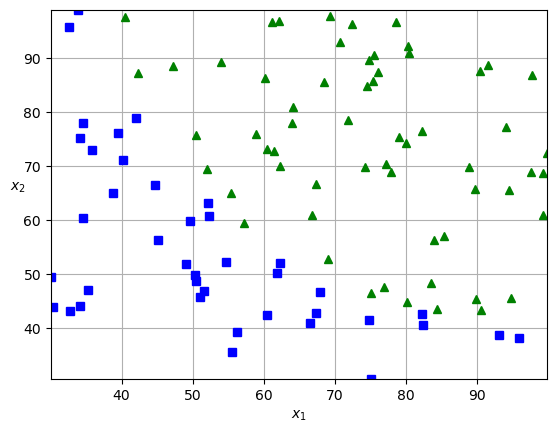

In [28]:
axes = [np.min(X[:,0]), np.max(X[:, 0]), np.min(X[:, 1]),np.max(X[:,1])]
plot_dataset(X, y, axes)

In [31]:
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
linear_svc = make_pipeline(StandardScaler(), LinearSVC(loss="hinge", C=1, dual=True, random_state=42))
linear_svc.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc',
                 LinearSVC(C=1, dual=True, loss='hinge', random_state=42))])

In [42]:
svc = make_pipeline(StandardScaler(), SVC(kernel="linear", C=1, tol=1e-6))
svc.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=1, kernel='linear', tol=1e-06))])

In [43]:
m = X.shape[0]
sgd_clf = make_pipeline(StandardScaler(), SGDClassifier(alpha=0.5/m, tol=None, eta0=0.1, learning_rate="invscaling", max_iter=10000))
sgd_clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdclassifier',
                 SGDClassifier(alpha=0.005, eta0=0.1,
                               learning_rate='invscaling', max_iter=10000,
                               tol=None))])

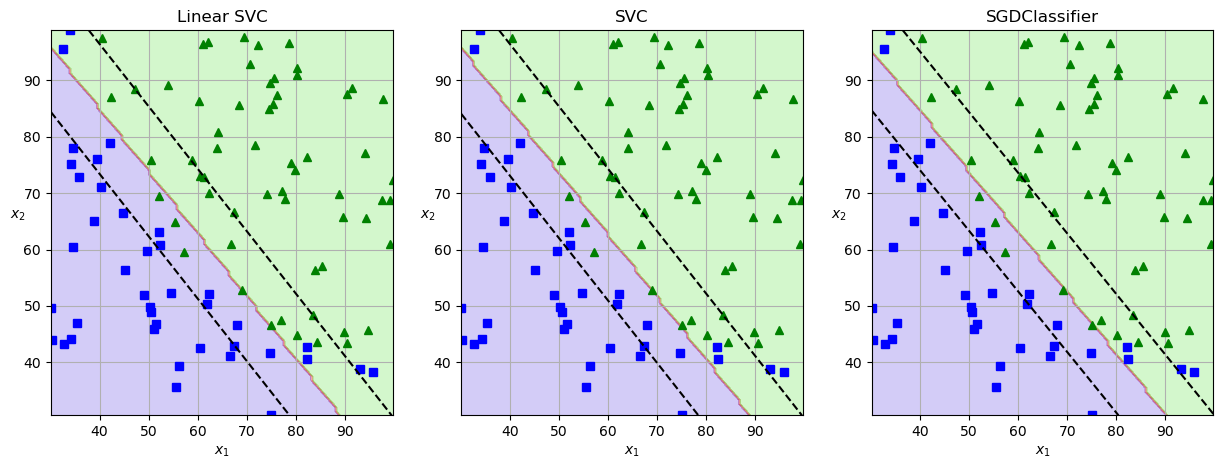

In [44]:
plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)
plot_dataset(X,y, axes)
plot_predictions(linear_svc, axes=axes)
plt.title("Linear SVC")

plt.subplot(1,3,2)
plot_dataset(X,y, axes)
plot_predictions(svc, axes=axes)
plt.title("SVC")

plt.subplot(1,3,3)
plot_dataset(X,y, axes)
plot_predictions(sgd_clf, axes=axes)
plt.title("SGDClassifier")
plt.show()